# Airbnb New User Bookings
*Where will a new guest book their first travel experience?*

* [Kaggle Page](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings)

**Outline**

* [Read Data](#read)
* [Data Summary](#data check)
* [Exploratory Data Analysis](#eda)
* [Feature Creation and Preprocessing](#preprocess)
* [Model and Score](#model) 
* [Predicition](#predict)
* [Reference](#reference)

**Related Notebooks**
- Link to [Airbnb 2.26.18 - Model Development & Evaluation](Airbnb 2.26.18 - Model Development & Evaluation.ipynb)

In [1]:
#%load_ext watermark

In [37]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier

SEED = 12345

In [3]:
#%watermark -a 'PredictiveII' -d -t -v -p pandas,numpy,sklearn,watermark

---

## <a id="read">Read Data</a>

In [38]:
def data_reader():
    """
    read data into notebook 
    """
        
    data_dir = os.path.join('.', 'data') #/Users/siliangchen/Airbnb

    session_path = os.path.join(data_dir, 'sessions.csv')
    train_path = os.path.join(data_dir, 'train_users_2.csv')    
    test_path = os.path.join(data_dir, 'test_users.csv')   
    age_gender_bkt_path = os.path.join(data_dir, 'age_gender_bkts.csv')   
    country_path = os.path.join(data_dir, 'countries.csv')   
    sample_submission_path = os.path.join(data_dir, 'sample_submission_NDF.csv')   

    session = pd.read_csv(session_path)
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    age_gender = pd.read_csv(age_gender_bkt_path)
    country = pd.read_csv(country_path)
    sample_submission = pd.read_csv(sample_submission_path)

    
    return session, train, test, age_gender, country, sample_submission

In [39]:
session, train, test, age_gender, country, sample_submission = data_reader()

## <a id="data check">Data Summary</a>

### Data dictionary:
** Table 1. Session: web sessions log for users (can be joined with tables for additional feature extraction)**
* **user_id**: to be joined with the column 'id' in users table
* **action**
* **action_type**
* **action_detail**
* **device_type**
* **secs_elapsed**

** Table 2. Train user: the training set of users**
* **id**: user id
* **date_account_created**: the date of account creation
* **timestamp_first_active**: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up.
* **date_first_booking**: date of first booking
* **gender**
* **age**
* **signup_method**
* **signup_flow**: the page a user came to signup up from
* **language**: international language preference
* **affiliate_channel**: what kind of paid marketing
* **affiliate_provider**: where the marketing is e.g. google, craigslist, other
* **first_affiliate_tracked**: whats the first marketing the user interacted with before the signing up
* **signup_app**
* **first_device_type**
* **first_browser**
* **country_destination**: this is the target variable you are to predict

** Table 3. age_gender: summary statistics of users' age group, gender, country of destination **

** Table 4. country: summary statistics of destination countries in this dataset and their locations **

** Table 5. test user: the testing set of users **

### Data inspection, clean and feature engineering:
### Session
1. missing data (34496 user_id = NaN, 0.3% of total rows, dropped and saved a session_v1)
2. added features based on time spent and actions
3. rollup data and extract features

In [40]:
#Data overview
unique_user_count = len(set(session["user_id"])) #135484 unique users in session
print(session.shape)
session.head(2)
null_userid = session[pd.isnull(session["user_id"])]
len(null_userid) #can't use these consecutive null user ids link information, drop these user IDs later

(10567737, 6)


34496

In [41]:
session.tail(3)
session["device_type"].value_counts()
session["action_type"].value_counts()

view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

### Train
1. max(age) = 2014 is obvriously wrong, need to check on age column and recompute
2. many columns have missing information that need to be taken care of
2. lots of gender unknown

In [42]:
#check each row has a unique user id
print(train.shape)
unique_user_count = len(set(train["id"]))
print(unique_user_count)

#check summary stats
train.head(5)
train.describe(include = "all") #many cols have missing information

(213451, 16)
213451


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,213451,213451,2.134510e+05,88908,213451,125461.000000,213451,213451.000000,213451,213451,213451,207386,213451,213451,213451,213451
unique,213451,1634,NaN,1976,4,NaN,3,NaN,25,8,18,7,4,9,52,12
top,atbvwqdo1n,2014-05-13,NaN,2014-05-22,-unknown-,NaN,basic,NaN,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,1,674,NaN,248,95688,NaN,152897,NaN,206314,137727,137426,109232,182717,89600,63845,124543
mean,NaN,NaN,2.013085e+13,NaN,NaN,49.668335,NaN,3.267387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,9.253717e+09,NaN,NaN,155.666612,NaN,7.637707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2.009032e+13,NaN,NaN,1.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.012123e+13,NaN,NaN,28.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.013091e+13,NaN,NaN,34.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.014031e+13,NaN,NaN,43.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
#age distribution
print(train.age.describe())
print(len(train[train["age"]>90])) #jc: 1.2% of age above 90, drop these? team decision
#train[train["age"]>90]

#train['date_first_booking']

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64
2543


In [44]:
train[train.age>1000].age.value_counts()
#some of these are years rather than age

2014.0    710
2013.0     39
1932.0      3
1931.0      3
1949.0      3
1924.0      2
1936.0      2
1947.0      2
1929.0      2
1928.0      2
1952.0      1
1938.0      1
1933.0      1
1927.0      1
1942.0      1
1995.0      1
2008.0      1
1953.0      1
1926.0      1
1925.0      1
1935.0      1
Name: age, dtype: int64

In [11]:
#train[(train.age>90) & (train.age<1000)].age.value_counts()
#train[(train.age<15)].age.value_counts()

In [45]:
def ageTransform(age):
    """
    Replace strange ages
    """
    current_year = 2014
    if (age>2000):
        new_age = 34 #replace it with median
    elif (age>1000):
        new_age = 2014-age+1
    elif (age>100):
        new_age = 90 
    elif (age<10):
        new_age = 34 #replace it with median
    elif (math.isnan(age)):
        new_age = 34 #replace it with median
    else:
        new_age = age                    

    return new_age   

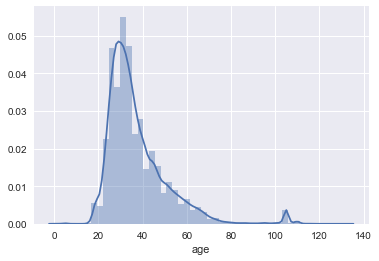

In [46]:
# Original Age Distribution
train_age = train[(train.age.notnull()) & (train.age<150)]
sn.distplot(train_age['age'])

In [47]:
train['age'] = train['age'].apply(lambda x: ageTransform(x))

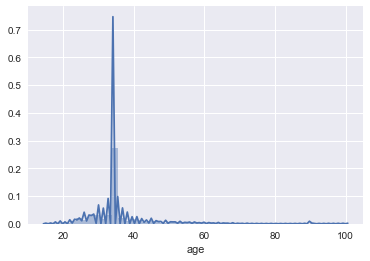

In [48]:
# New Age Distribution, replace lots of NaN's with median, which is 34.
sn.distplot(train['age'])

In [49]:
train.age.describe()

count    213451.000000
mean         35.892186
std          10.113310
min          15.000000
25%          32.000000
50%          34.000000
75%          35.000000
max         100.000000
Name: age, dtype: float64

### Age_gender

In [50]:
age_gender.shape
age_gender.head(5)
#set(age_gender["year"])

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


summary statistics of users' age group, gender, country of destination

## country

correct format for submitting your predictions

In [51]:
country.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


### Test
* merge session with test and see how many got merged

In [52]:
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [53]:
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [54]:
#merge sessions with test data
pd.merge(test, session, how='left',left_on = 'id',right_on = 'user_id')

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_affiliate_tracked,signup_app,first_device_type,first_browser,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,show,view,user_profile,-unknown-,79.0
1,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,search,click,view_search_results,-unknown-,17962.0
2,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,search,click,view_search_results,-unknown-,64883.0
3,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,show,view,p3,-unknown-,31180.0
4,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,authenticate,submit,login,iPhone,NaN
5,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,reviews,data,listing_reviews,-unknown-,1097.0
6,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,active,-unknown-,-unknown-,-unknown-,1046.0
7,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,5uwns89zht,search,click,view_search_results,-unknown-,2940.0
8,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,jtl0dijy2j,dashboard,view,dashboard,iPhone,747.0
9,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,...,untracked,Moweb,iPhone,Mobile Safari,jtl0dijy2j,login,view,login_page,iPhone,3228.0


In [22]:
test.head()
min(test['date_account_created'])

'2014-07-01'

---

## Data Transformation

**Train**
1. age transform
2. replace na in first_affiliate_tracked with untracked
3. rename column id to user_id 

In [55]:
def ageTransform(age):
    """
    Replace strange ages
    """
    current_year = 2014
    if (age>2000):
        new_age = 34 #replace it with median
    elif (age>1000):
        new_age = 2014-age+1
    elif (age>100):
        new_age = 90 
    elif (age<10):
        new_age = 34 #replace it with median
    elif (math.isnan(age)):
        new_age = 34 #replace it with median
    else:
        new_age = age                    

    return new_age   

In [56]:
def train_cleaner(train):
    """
    data transformation for train dataframe
    """
    df = train.copy()
    
    # replace strange ages
    df['age'] = df['age'].apply(lambda x: ageTransform(x))
    
    # replace value with most common values, which is "untracked"
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].fillna('untracked')
    
    # change column name id into user_id in order to merge with session data
    df = df.rename(columns={'id':'user_id'})
    
    return df

In [57]:
train = train_cleaner(train)

**Session**
1. drop user_id = na because these info can't be used
2. feature engineer after grouping by user_id

In [58]:
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


## Additional Feature Variables using Sessions Table

In [59]:
session.action.nunique()

359

In [60]:
actions = pd.DataFrame(session['action'].value_counts().reset_index())
actions_top10 = actions.head(10)
actions_top10

,index,action
0,show,2768278
1,index,843699
2,search_results,725226
3,personalize,706824
4,search,536057
5,ajax_refresh_subtotal,487744
6,update,365130
7,similar_listings,364624
8,social_connections,339000
9,reviews,320591


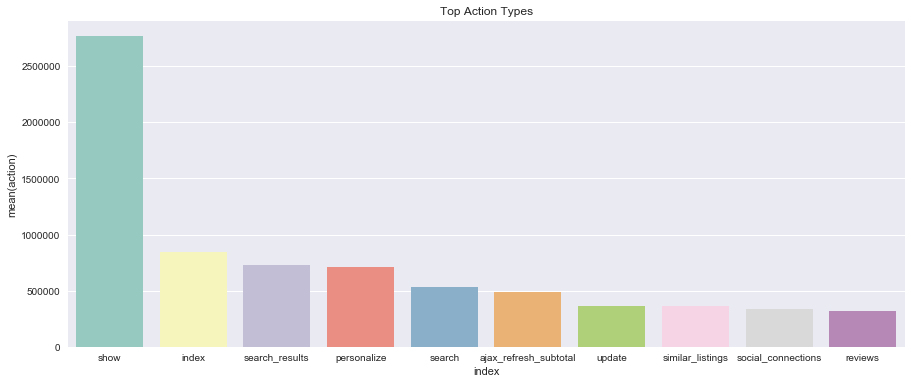

In [24]:
plt.subplots(figsize=(15, 6))
sn.barplot(actions_top10['index'],actions_top10['action'], palette="Set3").set_title('Top Action Types')

In [61]:
session.action.value_counts().head(20)

show                     2768278
index                     843699
search_results            725226
personalize               706824
search                    536057
ajax_refresh_subtotal     487744
update                    365130
similar_listings          364624
social_connections        339000
reviews                   320591
active                    188036
similar_listings_v2       168788
lookup                    162041
create                    155887
dashboard                 152952
header_userpic            141830
collections               124417
edit                      109083
campaigns                 105028
track_page_view            81117
Name: action, dtype: int64

In [62]:
session.action_detail.nunique()

155

In [63]:
session.action_detail.value_counts().head(20)

view_search_results            1776885
p3                             1376550
-unknown-                      1031141
wishlist_content_update         706824
user_profile                    656839
change_trip_characteristics     487744
similar_listings                364624
user_social_connections         336799
update_listing                  269779
listing_reviews                 269021
dashboard                       152952
user_wishlists                  152672
header_userpic                  141830
message_thread                  132395
edit_profile                    108686
message_post                     87103
contact_host                     81041
unavailable_dates                77795
confirm_email_link               58422
create_user                      54878
Name: action_detail, dtype: int64

In [67]:
def get_action_counts(frame,action_list):
    """
    gets count of select action types for each user
    """
    action_subset = frame[frame['action'].isin(action_list)]
    action_counts = pd.crosstab(action_subset['user_id'],action_subset['action'])
    action_counts['action_count_tot'] = action_counts['index'] + action_counts['personalize'] + action_counts['reviews'] + action_counts['search'] + action_counts['search_results'] + action_counts['show'] + action_counts['similar_listings']
    return action_counts

In [68]:
#top actions are the 
top_actions = ['show','index','search_results','personalize','search','similar_listings','reviews']
user_actions = get_action_counts(session,top_actions).reset_index()
user_actions.head()

action,user_id,index,personalize,reviews,search,search_results,show,similar_listings,action_count_tot
0,00023iyk9l,4,4,0,0,1,9,3,21
1,0010k6l0om,5,8,0,0,8,20,0,41
2,001wyh0pz8,2,0,0,66,0,6,0,74
3,0028jgx1x1,0,0,5,9,0,15,0,29
4,002qnbzfs5,115,0,13,125,0,232,0,485


In [79]:
train_session_v2 = pd.merge(user_actions,train_session, on='user_id', how='inner')
train_session_v2.head()

,user_id,index,personalize,reviews,search,search_results,show,similar_listings,action_count_tot,obs_count,...,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,isNDF
0,00023iyk9l,4,4,0,0,1,9,3,21,40,...,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,False
1,001wyh0pz8,2,0,0,66,0,6,0,74,90,...,23,en,direct,direct,untracked,Android,Other/Unknown,-unknown-,NDF,True
2,0028jgx1x1,0,0,5,9,0,15,0,29,31,...,0,en,direct,direct,linked,Moweb,Android Phone,Android Browser,NDF,True
3,002qnbzfs5,115,0,13,125,0,232,0,485,789,...,25,en,direct,direct,linked,iOS,iPhone,Mobile Safari,US,False
4,0035hobuyj,23,26,0,0,180,47,12,288,489,...,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,US,False


**Comparing action counts between users who did/did not make a booking**

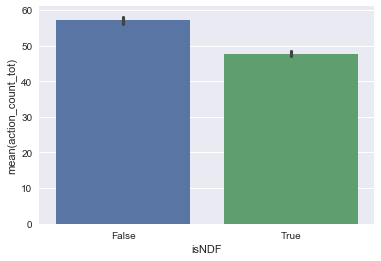

In [81]:
plt.subplots(figsize=(6, 4))
sn.barplot(train_session_v2['isNDF'],train_session_v2['action_count_tot'])

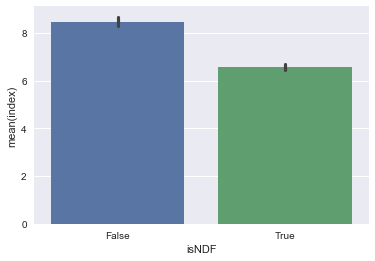

In [80]:
plt.subplots(figsize=(6, 4))
sn.barplot(train_session_v2['isNDF'],train_session_v2['index'])

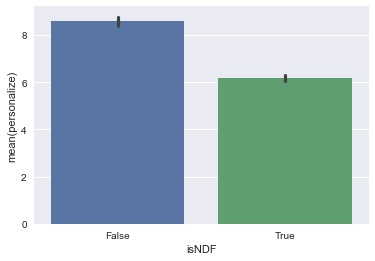

In [60]:
plt.subplots(figsize=(6, 4))
sn.barplot(train_session_v2['isNDF'],train_session_v2['personalize'])

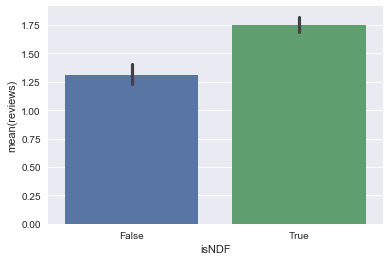

In [65]:
plt.subplots(figsize=(6, 4))
sn.barplot(train_session_v2['isNDF'],train_session_v2['reviews'])

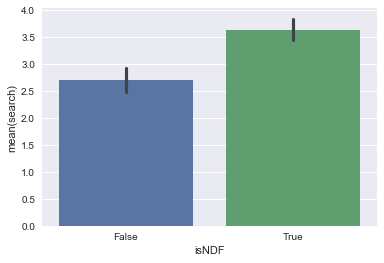

In [61]:
plt.subplots(figsize=(6, 4))
sn.barplot(train_session_v2['isNDF'],train_session_v2['search'])

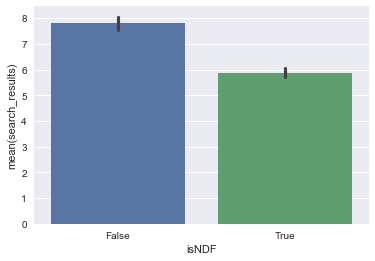

In [62]:
plt.subplots(figsize=(6, 4))
sn.barplot(train_session_v2['isNDF'],train_session_v2['search_results'])

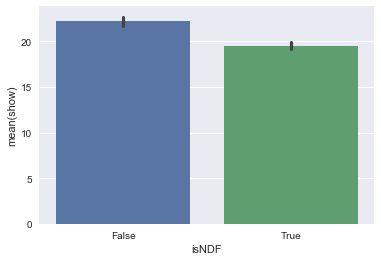

In [63]:
plt.subplots(figsize=(6, 4))
sn.barplot(train_session_v2['isNDF'],train_session_v2['show'])

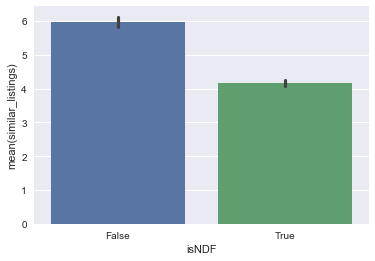

In [64]:
plt.subplots(figsize=(6, 4))
sn.barplot(train_session_v2['isNDF'],train_session_v2['similar_listings'])

In [71]:
def session_cleaner(session):
    """
    """
    
    # drop rows where userid is null
    session_v1 = session.dropna(axis = 0, subset = ["user_id"])            
    return session_v1

In [72]:
def session_feature_engineer(session_v1):
    """
    feature engineer for cleaned session table
    """
    
    session_v2 = session_v1.groupby(['user_id']).agg({'user_id':'count',
                                                  'action':'nunique',
                                                  'secs_elapsed':'sum',
                                                  'device_type': 'nunique',
                                                 }).rename(columns={'user_id': 'obs_count', 
                                                                    'action': 'unique_action',
                                                                   'secs_elapsed': 'total_secs_elapsed',
                                                                   'device_type': 'unique_device'}).reset_index()
    session_v2['avg_time'] = session_v2["total_secs_elapsed"]/session_v2["obs_count"]
    
    session_v2 = session_v2[session_v2.total_secs_elapsed.notnull()]
    
    return session_v2

In [73]:
session_v1 = session_cleaner(session)

In [74]:
session_v2 = session_feature_engineer(session_v1)

In [39]:
session_v2.head()

,user_id,obs_count,unique_action,total_secs_elapsed,unique_device,avg_time
0,00023iyk9l,40,13,867896.0,2,21697.400000
1,0010k6l0om,63,11,586543.0,1,9310.206349
2,001wyh0pz8,90,10,282965.0,1,3144.055556
3,0028jgx1x1,31,5,297010.0,2,9580.967742
4,002qnbzfs5,789,25,6487080.0,2,8221.901141


## <a id="eda">Exploratory Data Analysis</a>

In [75]:
session_v2['avg_time'].mean()

26183.436726631953

**Merge train with session**

In [15]:
session_v2.head()

,user_id,obs_count,unique_action,total_secs_elapsed,unique_device,avg_time
0,00023iyk9l,40,13,867896.0,2,21697.400000
1,0010k6l0om,63,11,586543.0,1,9310.206349
2,001wyh0pz8,90,10,282965.0,1,3144.055556
3,0028jgx1x1,31,5,297010.0,2,9580.967742
4,002qnbzfs5,789,25,6487080.0,2,8221.901141


In [16]:
train.head()

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [76]:
train_session = pd.merge(session_v2,train, on='user_id', how='inner')

In [73]:
session_v2.head()

,user_id,obs_count,unique_action,total_secs_elapsed,unique_device,avg_time
0,00023iyk9l,40,13,867896.0,2,21697.400000
1,0010k6l0om,63,11,586543.0,1,9310.206349
2,001wyh0pz8,90,10,282965.0,1,3144.055556
3,0028jgx1x1,31,5,297010.0,2,9580.967742
4,002qnbzfs5,789,25,6487080.0,2,8221.901141


In [18]:
train.shape

(213451, 16)

In [19]:
session_v2.shape

(134057, 6)

In [20]:
train_session.shape

(72631, 21)

About 30% of training data got merged with session information

## Univariate Analysis

In [92]:
train_session_v2.head()

,user_id,index,personalize,reviews,search,search_results,show,similar_listings,action_count_tot,obs_count,...,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,isNDF
0,00023iyk9l,4,4,0,0,1,9,3,21,40,...,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,False
1,001wyh0pz8,2,0,0,66,0,6,0,74,90,...,23,en,direct,direct,untracked,Android,Other/Unknown,-unknown-,NDF,True
2,0028jgx1x1,0,0,5,9,0,15,0,29,31,...,0,en,direct,direct,linked,Moweb,Android Phone,Android Browser,NDF,True
3,002qnbzfs5,115,0,13,125,0,232,0,485,789,...,25,en,direct,direct,linked,iOS,iPhone,Mobile Safari,US,False
4,0035hobuyj,23,26,0,0,180,47,12,288,489,...,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,US,False


**First Browser**

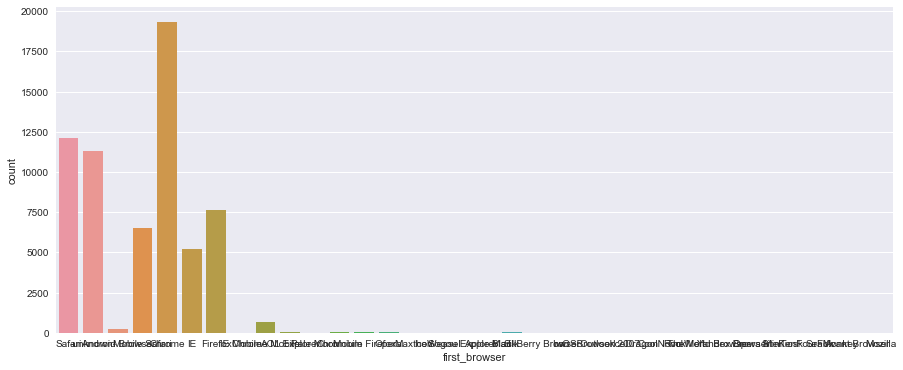

In [101]:
plt.subplots(figsize=(15, 6))
sn.countplot(train_session_v2['first_browser'],label=None)

**Relevant actions count**

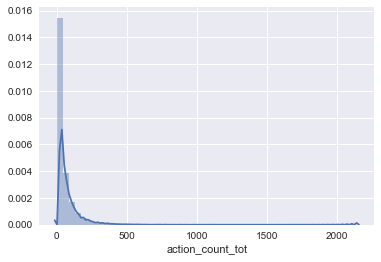

In [89]:
sn.distplot(train_session_v2['action_count_tot'])

**Observation Count**

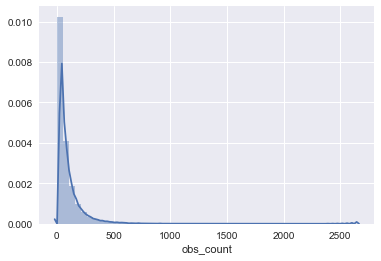

In [83]:
sn.distplot(train_session_v2['obs_count'])

** # of unique actions**

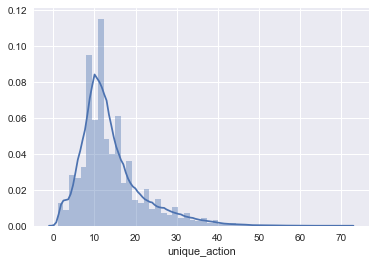

In [84]:
sn.distplot(train_session_v2['unique_action'])

** # of unique devices**

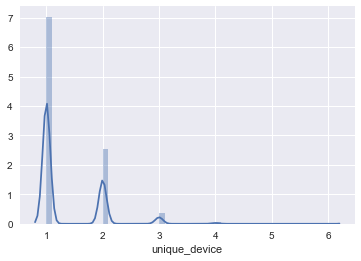

In [85]:
sn.distplot(train_session_v2['unique_device'])

**Average sessions time**

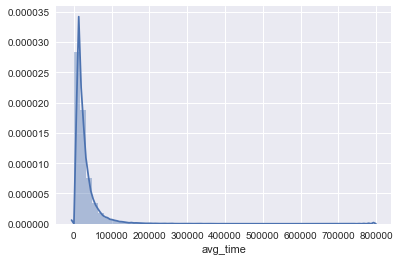

In [86]:
sn.distplot(train_session_v2['avg_time'])

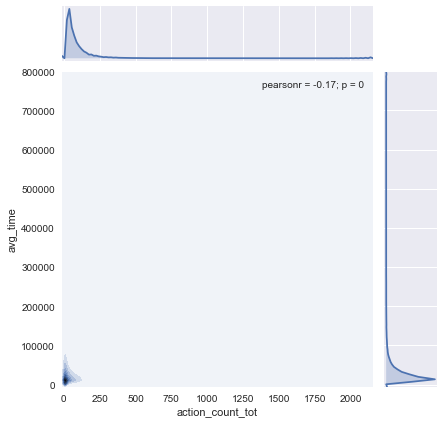

In [111]:
sn.jointplot(x=train_session_v2['action_count_tot'], y=train_session_v2['avg_time'], kind="kde")

**Add response binary variable on NDF**

In [78]:
train_session['isNDF'] = [True if x == 'NDF' else False for x in train_session['country_destination']]

In [22]:
train_session.isNDF.value_counts()/train_session.shape[0]

True     0.608858
False    0.391142
Name: isNDF, dtype: float64

In [23]:
train_session.isnull().sum()/train_session.shape[0]

user_id                    0.000000
obs_count                  0.000000
unique_action              0.000000
total_secs_elapsed         0.000000
unique_device              0.000000
avg_time                   0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.608858
gender                     0.000000
age                        0.000000
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.000000
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
isNDF                      0.000000
dtype: float64

In [47]:
train_session.to_csv('train_binary.csv') 
#we can use this file as final training data, or use all 21ktraining data without session info as training data

# Fit NDF Classifier

**Data Preparation**

In [24]:
train_binary = train_session.copy()
drop_feature = ['user_id', 'total_secs_elapsed', 'date_account_created','timestamp_first_active','date_first_booking','country_destination']
train_binary.drop(drop_feature, axis=1, inplace=True)

In [25]:
train_binary["first_browser"].value_counts()

Chrome                22496
Safari                14047
-unknown-             11911
Firefox                9031
Mobile Safari          7582
IE                     6287
Chrome Mobile           726
Android Browser         263
Opera                    60
Silk                     48
AOL Explorer             32
Chromium                 24
Mobile Firefox           18
IE Mobile                17
Sogou Explorer           13
Maxthon                  13
Apple Mail               13
BlackBerry Browser       10
SiteKiosk                 9
Yandex.Browser            7
IceWeasel                 5
Pale Moon                 3
Iron                      3
CoolNovo                  2
TheWorld Browser          1
RockMelt                  1
wOSBrowser                1
Avant Browser             1
Outlook 2007              1
Opera Mini                1
Googlebot                 1
TenFourFox                1
SeaMonkey                 1
IceDragon                 1
Mozilla                   1
Name: first_browser,

**Create Dummy Variable**

In [26]:
categorical = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel',
                'affiliate_provider','first_affiliate_tracked','signup_app','first_device_type',
               'first_browser']                           

In [27]:
# Convert data type as 'category'
for i in categorical:
    train_binary[i] = train_binary[i].astype('category')

In [28]:
# Create dummy variables
train_binary_dummy = pd.get_dummies(train_binary, columns = categorical)
train_binary_dummy.head()

,obs_count,unique_action,unique_device,avg_time,age,isNDF,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,...,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_Sogou Explorer,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,40,13,2,21697.400000,31.0,False,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,90,10,1,3144.055556,34.0,True,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,31,5,2,9580.967742,34.0,True,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,789,25,2,8221.901141,26.0,False,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,489,20,1,11706.891616,34.0,False,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


## Logistic Regression

**Validation Set Score**

In [29]:
# Split data into response and predictors
y = train_binary_dummy['isNDF']
x = train_binary_dummy.drop('isNDF', axis=1)

# Create training and test data tables
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .3, random_state = SEED)

# Fit logistic model
logreg = LogisticRegression().fit(x_train, y_train)

# Print out prediction accuracy for the data
print('Model accuracy on train set: {:.2f}'.format(logreg.score(x_train, y_train)))

Model accuracy on train set: 0.69


In [30]:
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.69


In [45]:
#coefficients = pd.DataFrame({"Feature":x_train.columns,"Coefficients":np.transpose(logreg.coef_)})

a = np.transpose(logreg.coef_[0])
coefficients = pd.DataFrame({"Feature":x_train.columns,"Coefficients":a}).sort_values(by='Coefficients',ascending=False)
coefficients

,Coefficients,Feature
5,1.041362,gender_-unknown-
10,0.596890,signup_method_facebook
88,0.342582,first_browser_-unknown-
44,0.285492,affiliate_channel_content
59,0.227184,affiliate_provider_google
71,0.198994,first_affiliate_tracked_omg
75,0.198003,signup_app_Android
83,0.158487,first_device_type_Other/Unknown
2,0.156341,unique_device
87,0.152041,first_device_type_iPhone


**Cross Validation Score**

In [29]:
kfold = model_selection.KFold(n_splits=10, random_state = SEED)
modelCV = LogisticRegression()
scoring = 'roc_auc'
results = model_selection.cross_val_score(modelCV, x_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average AUC: %.3f" % (results.mean()))

10-fold cross validation average AUC: 0.724


In [85]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[[ 3761  4671]
 [ 2095 11263]]
             precision    recall  f1-score   support

      False       0.64      0.45      0.53      8432
       True       0.71      0.84      0.77     13358

avg / total       0.68      0.69      0.68     21790



**To Do**

* Feature Selection
* Model Summary (significant features...etc)

**Reference**

* [Building A Logistic Regression in Python, Step by Step](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)
* [Scoring Metric](http://scikit-learn.org/0.15/modules/model_evaluation.html)